## Imports + DataFetcher

In [1]:
# =========================
# IMPORTS
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import requests
import yfinance as yf
import lightgbm as lgb


In [2]:
# =========================
# 1) DATA FETCHER
# =========================
import yfinance as yf
import pandas as pd

class DataFetcher:
    """
    Orchestrates the retrieval of historical market data from Yahoo Finance.    
    This class handles the management of ticker lists (including a benchmark)
    and wraps the yfinance download function to provide a unified interface
    for data acquisition.
    """
    
    def __init__(self, tickers, benchmark_ticker="^GSPC"):
        """
        Initializes the DataFetcher with target assets and a benchmark.

        Args:
            tickers (str or list): A single ticker symbol (e.g., "AAPL") or a list 
                                   of symbols (e.g., ["AAPL", "MSFT"]).
            benchmark_ticker (str, optional): The ticker symbol for the market reference 
                                              (e.g., "^GSPC" for S&P 500). Defaults to "^GSPC".
        """
        # Ensure tickers is a list
        self.tickers = tickers if isinstance(tickers, list) else [tickers]
        self.benchmark = benchmark_ticker
        
        # Create a unique list of all tickers including the benchmark
        self.all_tickers = list(set(self.tickers + [benchmark_ticker]))

    def download_data(self, start_date, end_date):
        """
        Downloads historical data for all initialized tickers over a specified period.
        Uses Yahoo Finance's auto-adjust feature to handle splits and dividends 
        automatically.
        Args:
            start_date (str): The start date for the data in 'YYYY-MM-DD' format.
            end_date (str): The end date for the data in 'YYYY-MM-DD' format.

        Returns:
            pd.DataFrame: A pandas DataFrame containing the OHLCV data. 
                          If multiple tickers are present, the columns will be a MultiIndex.
        """
        print(f"Downloading data for {len(self.all_tickers)} assets...")
        data = yf.download(
            self.all_tickers,
            start=start_date,
            end=end_date,
            auto_adjust=True,
            progress=False
        )
        return data

In [3]:
# =========================
# 2) SIMPLE HELPERS (prices / panel)
# =========================
def extract_close_prices(data: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the 'Close' prices from a yfinance MultiIndex DataFrame.
    Validates that the input DataFrame has the expected MultiIndex structure
    (Price, Ticker) and contains a 'Close' level.
    Args:
        data (pd.DataFrame): Raw DataFrame downloaded from yfinance with 
                             group_by='column' (MultiIndex columns).
    Returns:
        pd.DataFrame: A DataFrame containing only the closing prices, 
                      sorted by date.
    Raises:
        ValueError: If the input DataFrame columns are not a MultiIndex.
        KeyError: If the 'Close' level is missing from the columns.
    """
    if not isinstance(data.columns, pd.MultiIndex):
        raise ValueError("Expected MultiIndex columns from yfinance")
    if "Close" not in data.columns.get_level_values(0):
        raise KeyError("No 'Close' in data")
    return data["Close"].sort_index()

def filter_universe(prices: pd.DataFrame, min_non_nan_ratio=0.9) -> List[str]:
    """
    Filters the asset universe to keep only tickers with sufficient data quality.
    Calculates the ratio of missing values (NaN) for each ticker and retains
    only those that meet the minimum data completeness threshold.
    Args:
        prices (pd.DataFrame): A DataFrame of asset prices (Index=Date, Columns=Tickers).
        min_non_nan_ratio (float, optional): The minimum required fraction of non-NaN 
                                             values (0.0 to 1.0). Defaults to 0.9 (90% data required).
    Returns:
        List[str]: A list of ticker symbols that passed the quality filter.
    """
    nan_ratio = prices.isna().mean()
    keep = nan_ratio <= (1.0 - min_non_nan_ratio)
    tickers = list(prices.columns[keep])
    print(f"[OK] Universe: {len(tickers)} / {prices.shape[1]} kept")
    return tickers

def to_panel(data: pd.DataFrame, tickers: List[str]) -> pd.DataFrame:
    """
    Converts yfinance MultiIndex data into a long-format panel DataFrame.
    Transforms the data from a 'wide' format (Tickers as columns) to a 'long' 
    format (Date and Ticker as rows), ensuring all OHLCV fields are aligned.
    Args:
        data (pd.DataFrame): Raw yfinance MultiIndex DataFrame.
        tickers (List[str]): A list of valid ticker symbols to include in the panel.

    Returns:
        pd.DataFrame: A long-format DataFrame with columns: 
                      ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume'],
                      sorted by Date and Ticker.
    """
    fields = ["Open", "High", "Low", "Close", "Volume"]
    frames = []
    for f in fields:
        tmp = data[f][tickers].stack().rename(f).reset_index()
        tmp.columns = ["Date", "Ticker", f]
        frames.append(tmp)
    df = frames[0]
    for g in frames[1:]:
        df = df.merge(g, on=["Date", "Ticker"], how="inner")
    return df.sort_values(["Date", "Ticker"]).reset_index(drop=True)

## Transforms + FeatureFactory

In [4]:
# =========================
# 3) TRANSFORMS
# =========================
class Transforms:
    @staticmethod
    def phi_baz(x):
        return x / np.sqrt(1.0 + x**2)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

In [5]:
# =========================
# 4) FEATURES
# =========================
class FeatureFactory:
    """
    A centralized factory for generating and managing financial features.
    This class orchestrates the creation of technical indicators, 
    market-neutral (hedged) features, and complex volatility-adjusted 
    signals. It maintains a registry of all created feature names to 
    simplify downstream selection for machine learning models.
    """

    def __init__(self):
        """
        Initializes the FeatureFactory with an empty registry.
        """
        self.created: List[str] = []

    def add_basic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Computes fundamental price and volume indicators.
        Calculates:
        - close_1d_ret: Daily returns.
        - open_close_ret: Intraday returns (Open to Close).
        - high_low_ret: Daily volatility range (High to Low).
        - body_ratio: The ratio of the real body to the total range (conviction).
        - dollar_volume: Proxy for liquidity (Close * Volume).
        - turnover_proxy: Relative dollar volume compared to the daily cross-sectional mean.
        Args:
            df (pd.DataFrame): Long-format panel data with OHLCV columns.

        Returns:
            pd.DataFrame: The input DataFrame enriched with basic features.
        """
        out = df.copy()
        out["close_1d_ret"] = out.groupby("Ticker")["Close"].pct_change()
        out["open_close_ret"] = (out["Close"] - out["Open"]) / out["Open"]
        out["high_low_ret"] = (out["High"] - out["Low"]) / out["Low"]
        
        # + 1e-12 prevents division by zero for flat candles (Doji)
        out["body_ratio"] = out["open_close_ret"] / (out["high_low_ret"] + 1e-12)
        
        out["dollar_volume"] = out["Close"] * out["Volume"]
        
        # Normalize dollar volume by the daily average across all tickers
        out["turnover_proxy"] = out["dollar_volume"] / (out.groupby("Date")["dollar_volume"].transform("mean") + 1e-12)

        self.created += ["close_1d_ret", "open_close_ret", "high_low_ret", "body_ratio", "dollar_volume", "turnover_proxy"]
        return out

    def add_hedged(self, df: pd.DataFrame, col: str) -> pd.DataFrame:
        """
        Creates a market-neutral version of a specific feature.
        Subtracts the cross-sectional daily mean from the feature value.
        This isolates the asset-specific idiosyncratic movement (Alpha) 
        by removing the market-wide trend (Beta).
        Args:
            df (pd.DataFrame): The dataframe containing the column to hedge.
            col (str): The name of the column to neutralize.

        Returns:
            pd.DataFrame: Dataframe with the new '{col}_hedged' column added.
        """
        out = df.copy()
        out[f"{col}_hedged"] = out[col] - out.groupby("Date")[col].transform("mean")
        self.created.append(f"{col}_hedged")
        return out

    @staticmethod
    def _rolling_std_by_ticker(df: pd.DataFrame, col: str, window: int) -> pd.Series:
        """
        Helper method to calculate rolling standard deviation grouped by Ticker.
        Args:
            df (pd.DataFrame): Input dataframe.
            col (str): Target column.
            window (int): Rolling window size.

        Returns:
            pd.Series: Rolling standard deviation series, index-aligned.
        """
        return df.groupby("Ticker")[col].rolling(window).std().reset_index(level=0, drop=True)

    def add_macd_adjusted_features(self, df: pd.DataFrame, ret_col: str = "close_1d_ret", short_spans: List[int] = [8, 16, 32],
                                        long_spans:  List[int] = [24, 48, 96],
                                        windows:     List[int] = [21, 63, 126, 252],
                                        vol_window_first: int = 63,
                                    ) -> pd.DataFrame:
        """
        Generates advanced volatility-normalized MACD trend indicators.
        Creates two sets of features based on the MACD (Short EMA - Long EMA) logic, 
        applying a double-normalization process to make signals comparable across 
        assets and volatility regimes.

        Set 1:
        - Normalize MACD by a fixed rolling volatility (vol_window_first).
        - Z-score the result over the rolling `window`.

        Set 2:
        - Normalize MACD by the specific rolling volatility of the loop (`window`).
        - Z-score the result over a fixed annual window (252).

        Args:
            df (pd.DataFrame): Input panel data.
            ret_col (str): Return column used for calculation. Defaults to "close_1d_ret".
            short_spans (List[int]): Windows for short-term EMAs.
            long_spans (List[int]): Windows for long-term EMAs.
            windows (List[int]): Windows for Z-scoring and volatility normalization.
            vol_window_first (int): Fixed volatility window for the first feature set.

        Returns:
            pd.DataFrame: Dataframe enriched with adjusted MACD features.
        """
        out = df.copy()

        # FIRST set: Fixed vol normalization, variable Z-score window
        for window in windows:
            for i, (s, l) in enumerate(zip(short_spans, long_spans), start=1):
                ema_s = out.groupby("Ticker")[ret_col].transform(lambda x: x.ewm(span=s, adjust=False).mean())
                ema_l = out.groupby("Ticker")[ret_col].transform(lambda x: x.ewm(span=l, adjust=False).mean())
                macd = ema_s - ema_l

                vol1 = self._rolling_std_by_ticker(out, ret_col, vol_window_first)
                name = f"macd_adj_first_{window}_{i}"
                
                # Normalize signal by volatility
                out[name] = macd / (vol1 + 1e-12)
                # Standardize (Z-score) over the specific window
                out[name] = out.groupby("Ticker")[name].transform(lambda x: x / (x.rolling(window).std() + 1e-12))
                
                self.created.append(name)

        # SECOND set: Variable vol normalization, fixed annual Z-score window
        for window in windows:
            for i, (s, l) in enumerate(zip(short_spans, long_spans), start=1):
                ema_s = out.groupby("Ticker")[ret_col].transform(lambda x: x.ewm(span=s, adjust=False).mean())
                ema_l = out.groupby("Ticker")[ret_col].transform(lambda x: x.ewm(span=l, adjust=False).mean())
                macd = ema_s - ema_l

                vol2 = self._rolling_std_by_ticker(out, ret_col, window)
                name = f"macd_adj_second_{window}_{i}"
                
                # Normalize signal by specific window volatility
                out[name] = macd / (vol2 + 1e-12)
                # Standardize (Z-score) over a fixed annual horizon (252 days)
                out[name] = out.groupby("Ticker")[name].transform(lambda x: x / (x.rolling(252).std() + 1e-12))
                
                self.created.append(name)

        return out

    def add_transforms(self, df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
        """
        Applies non-linear transformations to selected columns.
        Uses external transform logic (e.g., Tanh, Phi) to compress outliers 
        or normalize distributions, making features more suitable for 
        neural networks.

        Args:
            df (pd.DataFrame): Input dataframe.
            cols (List[str]): List of column names to transform.

        Returns:
            pd.DataFrame: Dataframe with added '{col}_baz' and '{col}_tanh' columns.
        """
        out = df.copy()
        for c in cols:
            out[f"{c}_baz"] = Transforms.phi_baz(out[c])
            out[f"{c}_tanh"] = Transforms.tanh(out[c])
            self.created += [f"{c}_baz", f"{c}_tanh"]
        return out

## SignalFactory

In [6]:
# =========================
# 5) SIGNALS
# =========================
class SignalFactory:
    """
    A utility class for generating trading signals from feature scores.
    Provides static methods to create:
    1. Random benchmark signals (Monkey portfolio).
    2. Rank-based Long/Short signals (Decile/Quantile strategies).
    3. Time-lagged cross-sectional signals ready for backtesting.
    """

    @staticmethod
    def random_long_short(panel: pd.DataFrame, n_long: int = 35, n_short: int = 35, seed: int = 42) -> pd.Series:
        """
        Generates a random Long/Short signal for benchmarking purposes.
        For each date, it randomly assigns a fixed number of long (+1) and 
        short (-1) positions, with the rest being neutral (0). This simulates 
        a "Monkey Strategy" to test if a model's performance is statistically 
        significant compared to random chance.

        Args:
            panel (pd.DataFrame): Long-format dataframe containing a 'Date' index or column.
            n_long (int): Number of assets to buy per day. Defaults to 35.
            n_short (int): Number of assets to short per day. Defaults to 35.
            seed (int): Random seed for reproducibility. Defaults to 42.

        Returns:
            pd.Series: A series of signals {-1.0, 0.0, 1.0}, index-aligned with the input panel.
        """
        rng = np.random.default_rng(seed)

        def _assign(g: pd.DataFrame) -> pd.Series:
            n = len(g)
            # If not enough assets to fill the required positions, return neutral
            if n < n_long + n_short:
                return pd.Series(0.0, index=g.index)
            
            # Create the exact distribution of signals
            sig = np.array([1.0]*n_long + [-1.0]*n_short + [0.0]*(n - n_long - n_short))
            rng.shuffle(sig)
            return pd.Series(sig, index=g.index)

        return panel.groupby("Date", group_keys=False).apply(_assign)

    @staticmethod
    def decile_long_short(x: pd.Series, n_bins: int = 10) -> pd.Series:
        """
        Computes Long/Short signals based on quantile ranking (Reversal Logic).
        Ranks the input series `x` and bins it into `n_bins` (default 10).      
        Logic (Reversal / Mean Reversion):
        - Bin 0 (Lowest scores) -> +1.0 (LONG)
        - Bin N-1 (Highest scores) -> -1.0 (SHORT)
        - All other bins -> 0.0 (NEUTRAL)

        Note: To use this for Momentum (buying winners), one must invert the 
        input score or modify the mapping logic.

        Args:
            x (pd.Series): Input scores (e.g., returns, volatility).
            n_bins (int): Number of quantiles (10 for deciles, 5 for quintiles).

        Returns:
            pd.Series: Signal series {-1.0, 0.0, 1.0}.
        """
        if x.notna().sum() == 0:
            return pd.Series([np.nan]*len(x), index=x.index)
        
        # Rank data to handle outliers and different scales
        ranks = x.rank(method="first")
        
        # Discretize into bins
        binned = pd.cut(ranks, bins=n_bins, labels=False, include_lowest=True)
        
        # Map bins to signals: Buy bottom, Sell top
        return binned.map(lambda y: 1.0 if y == 0 else (-1.0 if y == n_bins-1 else 0.0))

    @staticmethod
    def cross_sectional_signal(panel: pd.DataFrame, score_col: str, lag: int = 1) -> pd.Series:
        """
        Orchestrates the creation of daily cross-sectional signals.

        1. Groups data by Date.
        2. Applies the ranking logic (`decile_long_short`) to the `score_col`.
        3. Shifts (lags) the resulting signal by `lag` days to prevent look-ahead bias.

        Args:
            panel (pd.DataFrame): Long-format dataframe with 'Date' and 'Ticker'.
            score_col (str): Name of the feature column to rank.
            lag (int): Number of days to shift the signal. 
                       Lag=1 means signals calculated on Close(t) are executed on Open(t+1).

        Returns:
            pd.Series: The final tradeable signal, aligned with the panel index.
        """
        # Apply ranking day by day
        raw = panel.groupby("Date")[score_col].transform(SignalFactory.decile_long_short)
        
        # Shift signal forward to simulate realistic execution
        return raw.groupby(panel["Ticker"]).shift(lag)

## Backtester + Plotter

In [7]:
# =========================
# 6) BACKTEST
# =========================
class Backtester:
    """
    A streamlined, vectorized backtesting engine.
    This class simulates the performance of trading signals by applying them 
    to historical returns. It assumes an 'Equally Weighted' portfolio allocation 
    method, where capital is split evenly among all active assets for a given day.
    
    It is designed for speed (vectorized operations) rather than high-fidelity 
    simulation (it ignores transaction costs and slippage).
    """

    def __init__(self, ret_col: str = "close_1d_ret"):
        """
        Initializes the backtester configuration.
        Args:
            ret_col (str): The name of the column in the panel data containing 
                           the 'ground truth' returns (e.g., 'close_1d_ret'). 
                           Defaults to "close_1d_ret".
        """
        self.ret_col = ret_col

    def daily_returns(self, panel: pd.DataFrame, signal: pd.Series) -> pd.Series:
        """
        Computes the daily portfolio PnL (Profit and Loss).
        Aligns the trading signals with the market data and calculates the 
        average return of the portfolio for each day.

        Logic:
            Daily PnL = Mean(Signal * Asset_Return)
        
        Note: This formula implies an Equal-Weight allocation. If the signal 
        is +1 for 10 assets, the backtester assumes 10% of capital is allocated 
        to each asset.

        Args:
            panel (pd.DataFrame): Long-format dataframe containing the return column.
            signal (pd.Series): Series of trading signals {-1, 0, 1}, index-aligned 
                                with the panel.

        Returns:
            pd.Series: A time series of the portfolio's daily percentage returns, 
                       indexed by Date.
        """
        tmp = panel.copy()
        tmp["_signal"] = signal
        # Group by Date and calculate the mean return of the active positions
        return tmp.groupby("Date").apply(lambda g: (g["_signal"] * g[self.ret_col]).mean())

    @staticmethod
    def sharpe(daily_ret: pd.Series, ann: int = 252) -> float:
        """
        Calculates the annualized Sharpe Ratio.
        Measures the risk-adjusted return of the portfolio.
        Formula: (Mean_Return / Std_Dev) * sqrt(252)
        
        Assumptions:
        - The risk-free rate (Rf) is 0.
        - Returns are normally distributed.

        Args:
            daily_ret (pd.Series): Time series of daily portfolio returns.
            ann (int, optional): Annualization factor (trading days per year). 
                                 Defaults to 252.

        Returns:
            float: The annualized Sharpe Ratio. Returns 0.0 if the series is empty.
        """
        mu = daily_ret.mean()
        sd = daily_ret.std(ddof=1)
        # 1e-12 added for numerical stability (prevent division by zero)
        return float(mu / (sd + 1e-12) * np.sqrt(ann))

In [8]:
class Plotter:
    """
    A static utility class for financial data visualization.
    Encapsulates standard plotting routines using Matplotlib to visualize 
    performance metrics, return distributions, and machine learning 
    optimization curves.
    """

    @staticmethod
    def plot_equity_curve(daily_ret: pd.Series, title: str = "Equity Curve"):
        """
        Visualizes the cumulative growth of a theoretical investment.
        Transforms a series of percentage returns into a wealth index 
        (Cumulative Product) starting at 1.0.

        Args:
            daily_ret (pd.Series): Time series of daily percentage returns.
            title (str, optional): Chart title. Defaults to "Equity Curve".
        """
        eq = (1.0 + daily_ret.fillna(0.0)).cumprod()
        plt.figure(figsize=(10,4))
        plt.plot(eq)
        plt.title(title)
        plt.xlabel("Date")
        plt.ylabel("Cumulative wealth")
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_cum_returns_compare(daily_returns: Dict[str, pd.Series], title: str = "Strategy Comparison"):
        """
        Overlays the cumulative performance of multiple strategies.
        Useful for benchmarking a strategy against the market (SPY) or 
        comparing different models (e.g., Momentum vs. Mean Reversion).

        Args:
            daily_returns (Dict[str, pd.Series]): Dictionary mapping names/labels 
                                                  to their respective return series.
            title (str, optional): Chart title. Defaults to "Strategy Comparison".
        """
        plt.figure(figsize=(10,4))
        for name, r in daily_returns.items():
            eq = (1.0 + r.fillna(0.0)).cumprod()
            plt.plot(eq, label=name)
        plt.title(title)
        plt.xlabel("Date")
        plt.ylabel("Cumulative wealth")
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_daily_return_hist(daily_ret: pd.Series, title: str = "Daily Returns Histogram"):
        """
        Displays the frequency distribution of daily returns.
        Helps analyze the statistical properties of the strategy, such as 
        volatility (width), skewness (asymmetry), and fat tails (kurtosis).

        Args:
            daily_ret (pd.Series): Time series of daily returns.
            title (str, optional): Chart title. Defaults to "Daily Returns Histogram".
        """
        plt.figure(figsize=(6,4))
        plt.hist(daily_ret.dropna(), bins=50)
        plt.title(title)
        plt.xlabel("Daily return")
        plt.ylabel("Count")
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_cv_curve(scores_by_alpha: Dict[float, float], title: str = "Expanding CV (MSE)"):
        """
        Plots hyperparameter tuning results (Error vs. Complexity).
        Visualizes how the Mean Squared Error (MSE) changes as the regularization 
        strength (alpha) varies. Typically used for Lasso/Ridge regression analysis.

        Args:
            scores_by_alpha (Dict[float, float]): Dictionary mapping alpha values (keys) 
                                                  to their corresponding MSE scores (values).
            title (str, optional): Chart title. Defaults to "Expanding CV (MSE)".
        """
        alphas = sorted(scores_by_alpha.keys())
        mses = [scores_by_alpha[a] for a in alphas]
        plt.figure(figsize=(7,4))
        plt.plot(alphas, mses, marker="o")
        plt.xscale("log")
        plt.title(title)
        plt.xlabel("alpha (log scale)")
        plt.ylabel("Mean CV MSE")
        plt.grid(True)
        plt.show()

## Features diagnostic

In [9]:
# =========================
# 7) FEATURE METRICS
# =========================
class FeatureReport:
    """
    A statistical diagnostic tool for evaluating feature predictive power (Alpha).
    This class performs univariate linear regression analysis to assess the 
    relationship between a specific feature and the target returns. It provides 
    metrics for signal strength (bias), directional accuracy (stability), and 
    time-series consistency (Sharpe of the signal).

    Attributes:
        fit_intercept (bool): Whether to calculate the intercept for the 
                              linear model. In quantitative finance, this is 
                              often False to enforce a 0-based expectation.
    """

    def __init__(self, fit_intercept: bool = False):
        """
        Initializes the FeatureReport.

        Args:
            fit_intercept (bool, optional): If True, the linear regression will 
                                            calculate an intercept. Defaults to False.
        """
        self.fit_intercept = fit_intercept

    def single_feature(self, df: pd.DataFrame, feature: str, target: str, drop_extreme_perc: bool = True, ts_bool: bool = False) -> Dict[str, Any]:
        """
        Performs a comprehensive analysis of a single feature against a target.

        Calculates global statistics (Beta, Bias, Stability) and optionally 
        generates a daily time-series analysis of the signal's efficacy.

        Metrics:
        - Beta Global: The slope of the regression line (Sensitivity).
        - Bias: The standard deviation of the predictions (Signal Strength).
        - Stability: The percentage of correct directional predictions (>50% is good).
        - Sharpe TS: The risk-adjusted return of the signal over time (if ts_bool=True).

        Args:
            df (pd.DataFrame): Input dataframe containing feature, target, and 'Date'.
            feature (str): Column name of the predictive feature (X).
            target (str): Column name of the target variable (y, usually returns).
            drop_extreme_perc (bool, optional): If True, winsorizes/drops the top and bottom 
                                                1% of outliers before regression. Defaults to True.
            ts_bool (bool, optional): If True, computes daily bias statistics and Sharpe ratio. 
                                      Defaults to False.

        Returns:
            Dict[str, Any]: A dictionary containing the calculated statistical metrics.
        """
        from sklearn.linear_model import LinearRegression

        dff = df[[feature, target, "Date"]].dropna().copy()

        # Remove 1% outliers to stabilize the global regression
        if drop_extreme_perc and len(dff) > 0:
            p1, p99 = np.percentile(dff[feature], [1, 99])
            dff = dff[(dff[feature] >= p1) & (dff[feature] <= p99)]

        reg = LinearRegression(fit_intercept=self.fit_intercept)
        reg.fit(dff[[feature]], dff[target])
        pred = reg.predict(dff[[feature]])

        beta_global = float(reg.coef_[0])
        # 'Bias' here refers to the standard deviation of the predictions (Signal Amplitude)
        bias = float(np.std(pred))
        # Stability: % of times prediction sign matches target sign
        stability = float((pred * dff[target] > 0).mean() * 100.0)

        out: Dict[str, Any] = {"bias": bias, "stability": stability, "beta_global": beta_global}

        if ts_bool:
            bias_ts = self.daily_bias_series(df, feature, target, beta_global)
            out["bias_ts"] = bias_ts
            out["mean_bias_ts"] = float(bias_ts.mean())
            # Calculate Sharpe Ratio of the signal's daily efficacy
            out["sharpe_ts"] = float(bias_ts.mean() / (bias_ts.std(ddof=1) + 1e-12) * np.sqrt(252))

        return out

    def daily_bias_series(self, df: pd.DataFrame, feature: str, target: str, beta_global: float) -> pd.Series:
        """
        Computes the daily strength and consistency of the feature.
        Performs a cross-sectional regression for every unique date in the dataset.
        Checks if the daily slope direction matches the global beta to determine
        if the signal worked as expected on that specific day.

        Args:
            df (pd.DataFrame): Input dataframe.
            feature (str): Feature column name.
            target (str): Target column name.
            beta_global (float): The global regression coefficient derived from `single_feature`.

        Returns:
            pd.Series: A time series representing the daily 'bias' (signal strength), 
                       adjusted for directional accuracy.
        """
        from sklearn.linear_model import LinearRegression

        dff = df[[feature, target, "Date"]].dropna().copy()

        def _one_day(g: pd.DataFrame) -> float:
            if len(g) < 2:
                return np.nan
            
            # Fit daily regression
            reg = LinearRegression(fit_intercept=False)
            reg.fit(g[[feature]], g[target])
            pred = reg.predict(g[[feature]])
            
            b = float(np.std(pred))
            
            # Check consistency: Did the daily relationship match the global expectation?
            # If the global slope is positive but today's slope is negative, the signal failed today.
            if float(reg.coef_[0]) * beta_global < 0:
                b *= -1
            return b

        return dff.groupby("Date").apply(_one_day)

## ML & Portfolio construction

In [10]:
# =========================
# 8) EXPANDING CV + WINSOR
# =========================
class Winsorizer:
    """
    A transformer for handling outliers by capping data at specified percentiles.

    This class limits extreme values in the data to reduce their impact on 
    linear models. Values below the lower quantile are replaced by the lower 
    bound, and values above the upper quantile are replaced by the upper bound.
    """

    def __init__(self, lower: float = 0.01, upper: float = 0.01):
        """
        Initializes the Winsorizer.

        Args:
            lower (float): The lower percentile to clip (e.g., 0.01 for 1%).
            upper (float): The upper percentile to clip (e.g., 0.01 for top 1%).
        """
        self.lower = lower
        self.upper = upper
        self.bounds_: Dict[str, Tuple[float, float]] = {}

    def fit(self, X: pd.DataFrame) -> "Winsorizer":
        """
        Computes the quantile bounds for each column.

        Note: In a proper ML pipeline, this must be called on the Training set 
        only to avoid data leakage (using future distribution knowledge).

        Args:
            X (pd.DataFrame): Input dataframe.

        Returns:
            Winsorizer: The fitted instance.
        """
        self.bounds_.clear()
        for c in X.columns:
            s = X[c].dropna()
            if len(s) == 0:
                self.bounds_[c] = (-np.inf, np.inf)
                continue
            lb = float(np.quantile(s, self.lower))
            ub = float(np.quantile(s, 1.0 - self.upper))
            self.bounds_[c] = (lb, ub)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Applies the learned bounds to clip values.

        Args:
            X (pd.DataFrame): Dataframe to transform.

        Returns:
            pd.DataFrame: A copy of X with outliers capped at the fitted bounds.
        """
        out = X.copy()
        for c, (lb, ub) in self.bounds_.items():
            out[c] = np.clip(out[c], lb, ub)
        return out

    def fit_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Fits the bounds and applies them in one step.

        Args:
            X (pd.DataFrame): Input dataframe.

        Returns:
            pd.DataFrame: Transformed dataframe.
        """
        return self.fit(X).transform(X)


@dataclass
class ExpandingCVConfig:
    """
    Configuration object for the Expanding Cross-Validation strategy.

    Attributes:
        n_splits (int): Number of time-series splits to perform.
        lower (float): Lower bound for Winsorization within the CV loop.
        upper (float): Upper bound for Winsorization within the CV loop.
    """
    n_splits: int = 5
    lower: float = 0.01
    upper: float = 0.01


class ExpandingCV:
    """
    Implements an Expanding Window Cross-Validation (Walk-Forward Validation).

    Unlike K-Fold, this respects the temporal order of financial data. 
    The training set expands over time, and the validation set follows 
    immediately after the training set, ensuring no future data leaks into 
    past training.
    """

    def __init__(self, cfg: ExpandingCVConfig):
        """
        Initializes the Cross-Validator with a configuration object.
        """
        self.cfg = cfg

    def splits(self, n: int) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Generates indices for the Training and Validation sets.

        The strategy starts with an initial training window (first 50% of data), 
        then incrementally adds chunks to the training set while moving the 
        validation window forward.

        Args:
            n (int): Total number of samples (rows) in the dataset.

        Returns:
            List[Tuple[np.ndarray, np.ndarray]]: A list of (train_indices, val_indices).
        """
        start = n // 2
        split_size = max(1, (n - start) // self.cfg.n_splits)

        splits: List[Tuple[np.ndarray, np.ndarray]] = []
        for k in range(1, self.cfg.n_splits + 1):
            train_end = start + k * split_size
            val_end = min(train_end + split_size, n)
            if val_end <= train_end:
                break
            splits.append((np.arange(0, train_end), np.arange(train_end, val_end)))
        return splits

    def score_mse(self, model, X: pd.DataFrame, y: pd.Series) -> List[float]:
        """
        Executes the cross-validation loop and calculates Mean Squared Error.

        Crucially, this method handles data leakage prevention by re-fitting
        the Winsorizer inside the loop:
        1. Split data into Train/Val.
        2. Fit Winsorizer on TRAIN.
        3. Transform TRAIN and VAL using those specific bounds.
        4. Train the model.
        5. Evaluate.

        Args:
            model: An sklearn-compatible model (must implement fit/predict).
            X (pd.DataFrame): Feature matrix.
            y (pd.Series): Target vector.

        Returns:
            List[float]: A list of MSE scores for each split.
        """
        from sklearn.metrics import mean_squared_error

        win = Winsorizer(lower=self.cfg.lower, upper=self.cfg.upper)
        mse_list: List[float] = []

        for tr, va in self.splits(len(X)):
            X_tr, y_tr = X.iloc[tr], y.iloc[tr]
            X_va, y_va = X.iloc[va], y.iloc[va]

            # Fit winsorizer on Train, apply to both Train and Val
            X_tr_w = win.fit_transform(X_tr)
            X_va_w = win.transform(X_va)

            model.fit(X_tr_w, y_tr)
            pred = model.predict(X_va_w)
            mse_list.append(float(mean_squared_error(y_va, pred)))

        return mse_list

In [11]:
# -------------------------
# 9) Alpha selection (Ridge) with ExpandingCV
# -------------------------
class RidgeAlphaSelector:
    """
    A hyperparameter tuning utility for Ridge Regression.

    This class automates the selection of the optimal regularization strength (alpha) 
    using an Expanding Window Cross-Validation strategy. It is designed to find 
    the model configuration that minimizes out-of-sample prediction error (MSE) 
    while respecting the temporal structure of financial data.
    """

    def __init__(self, cv: ExpandingCV):
        """
        Initializes the selector with a cross-validation strategy.

        Args:
            cv (ExpandingCV): An instance of the ExpandingCV class defining the 
                              validation splitting logic.
        """
        self.cv = cv

    def select_alpha(
        self,
        panel: pd.DataFrame,
        feature_cols: List[str],
        target_col: str,
        alphas: List[float],
        winsor_lower: float = 0.01,
        winsor_upper: float = 0.01,
        fit_intercept: bool = False,
    ) -> Tuple[float, Dict[float, float]]:
        """
        Performs a grid search to identify the best Ridge alpha.

        Iterates through a list of candidate alpha values. For each alpha:
        1. Instantiates a Ridge model.
        2. Configures a local ExpandingCV instance with specific Winsorization bounds.
        3. Computes the Mean Squared Error (MSE) across all validation splits.
        4. Selects the alpha that yields the lowest average MSE.

        Args:
            panel (pd.DataFrame): Input dataframe containing features and target.
            feature_cols (List[str]): List of column names to use as predictors (X).
            target_col (str): Column name of the target variable (y).
            alphas (List[float]): List of regularization strengths to test (e.g., [0.1, 1.0, 10.0]).
            winsor_lower (float, optional): Lower quantile for Winsorization inside CV. Defaults to 0.01.
            winsor_upper (float, optional): Upper quantile for Winsorization inside CV. Defaults to 0.01.
            fit_intercept (bool, optional): Whether to calculate the intercept. Defaults to False.

        Returns:
            Tuple[float, Dict[float, float]]: 
                - The best alpha value (float).
                - A dictionary mapping all tested alphas to their mean CV MSE scores.
        """
        # Build clean dataset (remove rows with NaNs in relevant columns)
        dff = panel[feature_cols + [target_col]].dropna()
        X = dff[feature_cols]
        y = dff[target_col]

        scores: Dict[float, float] = {}
        for a in alphas:
            model = Ridge(alpha=a, fit_intercept=fit_intercept)
            
            # Configure a local CV instance to ensure correct winsorization settings 
            # for this specific run (overriding the default if necessary)
            cv_local = ExpandingCV(ExpandingCVConfig(
                n_splits=self.cv.cfg.n_splits,
                lower=winsor_lower,
                upper=winsor_upper
            ))
            
            # Calculate MSE across all splits
            mse_list = cv_local.score_mse(model, X, y)
            scores[a] = float(np.mean(mse_list))

        # Identify the alpha with the minimum average error
        best_alpha = min(scores, key=scores.get)
        return best_alpha, scores

In [12]:
# -------------------------
# 10) Regress-then-rank model
# -------------------------
@dataclass
class RegressThenRankConfig:
    """
    Configuration for the RegressThenRank strategy pipeline.

    Attributes:
        feature_cols (List[str]): List of column names used as predictive features.
        target_col (str): The column name of the target variable (e.g., returns). Defaults to "close_1d_ret".
        alpha (float): Regularization strength for the Ridge regression. Defaults to 1.0.
        fit_intercept (bool): Whether to calculate an intercept for the model. Defaults to False.
        winsor_lower (float): Lower percentile for outlier clipping. Defaults to 0.01.
        winsor_upper (float): Upper percentile for outlier clipping. Defaults to 0.01.
        lag_signal (int): Number of days to lag the final signal to prevent look-ahead bias. Defaults to 1.
    """
    feature_cols: List[str]
    target_col: str = "close_1d_ret"
    alpha: float = 1.0                # Ridge alpha
    fit_intercept: bool = False
    winsor_lower: float = 0.01
    winsor_upper: float = 0.01
    lag_signal: int = 1               # to avoid look-ahead in portfolio construction


class RegressThenRank:
    """
    A two-step quantitative strategy: Regression followed by Ranking.

    This class implements a common workflow in factor investing:
    1. **Regression**: Trains a linear model (Ridge) to predict asset returns based on features.
    2. **Ranking**: Sorts assets based on these predicted returns (scores).
    3. **Signal Generation**: Builds a Long/Short portfolio by buying the top-ranked assets 
       and shorting the bottom-ranked assets.

    This approach captures the relative expected performance of assets (Cross-Sectional Alpha).
    """

    def __init__(self, cfg: RegressThenRankConfig):
        """
        Initializes the strategy with a configuration object.
        """
        self.cfg = cfg
        self.model = Ridge(alpha=cfg.alpha, fit_intercept=cfg.fit_intercept)
        self.winsor = Winsorizer(lower=cfg.winsor_lower, upper=cfg.winsor_upper)

    def _make_xy(self, panel: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Helper method to prepare feature matrix X and target vector y.

        Drops rows with missing values to ensure clean training data.

        Args:
            panel (pd.DataFrame): Input dataframe.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: 
                - Metadata dataframe (Date, Ticker).
                - Feature matrix X.
                - Target vector y.
        """
        cols = ["Date", "Ticker"] + self.cfg.feature_cols + [self.cfg.target_col]
        dff = panel[cols].dropna().copy()
        X = dff[self.cfg.feature_cols]
        y = dff[self.cfg.target_col]
        return dff[["Date", "Ticker"]], X, y

    def fit(self, panel_train: pd.DataFrame) -> "RegressThenRank":
        """
        Trains the Ridge regression model.

        1. Freezes the feature order to ensure consistency during prediction.
        2. Filters rows with missing data.
        3. Learns winsorization bounds from the training data.
        4. Transforms features (clips outliers).
        5. Fits the Ridge model.

        Args:
            panel_train (pd.DataFrame): Training dataset.

        Returns:
            RegressThenRank: The fitted instance (self).
        """
        self.feature_cols_ = list(self.cfg.feature_cols)  # freeze order

        sub = panel_train.dropna(subset=self.feature_cols_ + [self.cfg.target_col]).copy()
        X = sub[self.feature_cols_]
        y = sub[self.cfg.target_col].values
        
        # Fit winsorizer on train data to prevent look-ahead bias
        Xw = self.winsor.fit_transform(X)
        self.model.fit(Xw, y)
        return self

    def predict_scores(self, panel: pd.DataFrame) -> pd.Series:
        """
        Generates raw return predictions (scores) for the panel.

        Applies the trained model to new data. Handles missing data by returning 
        NaNs for rows where features are incomplete.

        Args:
            panel (pd.DataFrame): Dataset to score.

        Returns:
            pd.Series: A series of predicted returns, aligned with the panel index.
        """
        """
        Returns a Series indexed like panel, with NaN where features unavailable.
        """
        if not hasattr(self, "feature_cols_"):
            raise RuntimeError("Call fit() before predict_scores().")
        
        scores = pd.Series(index=panel.index, dtype=float)
        
        # IMPORTANT: always use same column order as during training
        sub = panel.dropna(subset=self.feature_cols_).copy()
        X = sub[self.feature_cols_]
        
        # Apply winsorization using bounds learned from training
        Xw = self.winsor.transform(X)
        
        # Force DataFrame with same column names/order (sklearn check passes)
        Xw = pd.DataFrame(Xw, columns=self.feature_cols_, index=X.index)
        
        pred = self.model.predict(Xw)
        scores.loc[sub.index] = pred
        return scores

    def scores_to_signal(self, panel: pd.DataFrame, scores: pd.Series) -> pd.Series:
        """
        Converts raw scores into tradeable Long/Short signals.

        1. Groups scores by Date.
        2. Ranks assets into deciles (0-9).
        3. Assigns Long (+1) to top decile, Short (-1) to bottom decile.
        4. Lags the signal by `lag_signal` days to respect trading causality.

        Args:
            panel (pd.DataFrame): Reference panel for grouping.
            scores (pd.Series): Predicted returns from the model.

        Returns:
            pd.Series: Tradeable signals {-1, 0, 1}.
        """
        tmp = panel.copy()
        tmp["_score"] = scores

        # Apply Cross-Sectional Ranking
        raw = tmp.groupby("Date")["_score"].transform(lambda s: SignalFactory.decile_long_short(s, n_bins=10))
        
        # Lag to avoid look-ahead: use yesterday's ranking to trade today
        sig = raw.groupby(tmp["Ticker"]).shift(self.cfg.lag_signal)
        return sig

    def fit_predict_signal(self, panel_train: pd.DataFrame, panel_test: pd.DataFrame) -> Tuple[pd.Series, pd.Series]:
        """
        Convenience method to run the full pipeline: Fit -> Predict -> Signal.

        Args:
            panel_train (pd.DataFrame): Data for training.
            panel_test (pd.DataFrame): Data for generating out-of-sample signals.

        Returns:
            Tuple[pd.Series, pd.Series]: 
                - Raw predicted scores for the test set.
                - Final tradeable signals for the test set.
        """
        self.fit(panel_train)
        scores_test = self.predict_scores(panel_test)
        signal_test = self.scores_to_signal(panel_test, scores_test)
        return scores_test, signal_test

    def mse(self, panel: pd.DataFrame) -> float:
        """
        Diagnostic metric: Calculates Mean Squared Error of the predictions.

        Compares the model's predicted returns against the actual realized returns.

        Args:
            panel (pd.DataFrame): Dataframe containing both features and the target column.

        Returns:
            float: The Mean Squared Error.
        """
        scores = self.predict_scores(panel)
        mask = scores.notna() & panel[self.cfg.target_col].notna()
        return float(mean_squared_error(panel.loc[mask, self.cfg.target_col], scores.loc[mask]))

## Learning-to-rank

### Data formatting

In [13]:
class LTRDatasetBuilder:
    """
    Constructs training datasets specifically formatted for Learning to Rank (LTR) models.

    Designed for use with gradient boosting frameworks like LightGBM (lambdarank).
    It transforms a standard financial panel (Date, Ticker, Returns) into a 
    ranking problem by converting continuous returns into discrete relevance labels
    on a daily cross-sectional basis.

    Structure generated:
    - X: Feature matrix (N_samples, N_features).
    - y: Integer relevance labels (0 to k-1).
    - group: Array indicating the number of assets per query (Date).
    """

    def __init__(self, feature_cols: List[str], target_col: str = "close_1d_ret", n_quantiles: int = 5, min_group_size: int = 5):
        """
        Initializes the dataset builder configuration.

        Args:
            feature_cols (List[str]): List of column names to use as input features.
            target_col (str, optional): Continuous target column to discretize (e.g., returns). 
                                        Defaults to "close_1d_ret".
            n_quantiles (int, optional): Number of relevance levels. 
                                         5 implies labels 0, 1, 2, 3, 4. Defaults to 5.
            min_group_size (int, optional): Minimum number of assets required on a date 
                                            to include that date in the dataset. Defaults to 5.
        """
        self.feature_cols = list(feature_cols)
        self.target_col = target_col
        self.n_quantiles = n_quantiles
        self.min_group_size = min_group_size

    def build(self, panel: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
        """
        Processes the panel data into LightGBM-compatible arrays.

        Workflow:
        1. Filters valid rows (no NaNs).
        2. Groups data by Date (Query).
        3. Discretizes the target variable into `n_quantiles` bins for each date.
           (e.g., Highest returns = Label 4, Lowest returns = Label 0).
        4. Aggregates features, labels, and group sizes.

        Args:
            panel (pd.DataFrame): Long-format dataframe with 'Date', 'Ticker', 
                                  features, and target.

        Returns:
            Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
                - X: Feature DataFrame.
                - y: Numpy array of integer relevance labels.
                - group: Numpy array where group[i] is the number of items in the i-th date.
        """
        df = panel.dropna(subset=self.feature_cols + [self.target_col]).copy()
        # Sorting by Date is crucial for LightGBM group boundaries
        df = df.sort_values(["Date", "Ticker"])

        X_list, y_list, group_list = [], [], []

        for date, g in df.groupby("Date", sort=True):
            # Skip days with insufficient liquidity/data to form a proper ranking
            if len(g) < self.min_group_size:
                continue

            # Generate relevance labels from cross-sectional quantiles of future returns
            # pd.qcut ensures roughly equal number of assets per label
            y = g[self.target_col]
            labels = pd.qcut(y, q=self.n_quantiles, labels=False, duplicates="drop").astype(int)

            X_list.append(g[self.feature_cols])
            y_list.append(labels.values)
            group_list.append(len(g))

        X = pd.concat(X_list, axis=0)
        y = np.concatenate(y_list)
        group = np.array(group_list, dtype=int)
        
        return X, y, group

### LTR — Modèles (LightGBM ranker)

In [14]:
class LightGBMRanker:
    """
    A wrapper for the LightGBM Learning-to-Rank (LTR) model.

    This class encapsulates the configuration and training of gradient boosting 
    models optimized for ranking tasks. Instead of minimizing regression error 
    (MSE), it optimizes Information Retrieval metrics like NDCG (Normalized 
    Discounted Cumulative Gain).

    Supported Objectives:
    - "lambdarank": Uses pairwise gradients to optimize the ranking order directly 
      (LambdaRank / LambdaMART). This is the standard for most LTR tasks.
    - "rank_xendcg": An alternative listwise objective focusing on Cross-Entropy 
      optimization for NDCG.
    """

    def __init__(
        self,
        objective: str = "lambdarank",
        n_estimators: int = 400,
        learning_rate: float = 0.05,
        num_leaves: int = 31,
        subsample: float = 0.8,
        colsample_bytree: float = 0.8,
        reg_lambda: float = 1.0,
        random_state: int = 42
    ):
        """
        Initializes the LightGBM Ranker with specific hyperparameters.

        Args:
            objective (str): The optimization objective ("lambdarank" or "rank_xendcg"). 
                             Defaults to "lambdarank".
            n_estimators (int): Number of boosting iterations (trees). Defaults to 400.
            learning_rate (float): The step size shrinkage used in update to prevent overfitting. 
                                   Defaults to 0.05.
            num_leaves (int): Max number of leaves in one tree. Controls complexity. 
                              Defaults to 31.
            subsample (float): Subsample ratio of the training instance (Row subsampling). 
                               Defaults to 0.8.
            colsample_bytree (float): Subsample ratio of columns when constructing each tree 
                                      (Feature subsampling). Defaults to 0.8.
            reg_lambda (float): L2 regularization term on weights. Defaults to 1.0.
            random_state (int): Random number seed for reproducibility. Defaults to 42.
        """
        self.objective = objective
        self.model = lgb.LGBMRanker(
            objective=objective,
            metric="ndcg",
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_lambda=reg_lambda,
            random_state=random_state
        )

    def fit(self, X: pd.DataFrame, y: np.ndarray, group: np.ndarray) -> "LightGBMRanker":
        """
        Trains the ranking model.

        The `group` parameter is critical: it tells the model which samples belong 
        to the same query (date). LightGBM will only compare items within the 
        same group.

        Args:
            X (pd.DataFrame): Feature matrix.
            y (np.ndarray): Target relevance labels (integers).
            group (np.ndarray): 1D array where group[i] is the number of items 
                                in the i-th group (query/date). Sum(group) must equal len(X).

        Returns:
            LightGBMRanker: The fitted instance (self).
        """
        self.model.fit(X, y, group=group)
        return self

    def predict_scores(self, X: pd.DataFrame) -> np.ndarray:
        """
        Generates ranking scores for new data.

        The output scores are not probabilities or direct return predictions, 
        but relative scores. An item with a higher score should be ranked higher 
        than an item with a lower score.

        Args:
            X (pd.DataFrame): Feature matrix for prediction.

        Returns:
            np.ndarray: Raw ranking scores.
        """
        return self.model.predict(X)

In [15]:
class ScoreToSignal:
    """
    Transforms raw model predictions into tradeable Long/Short signals.

    This class implements a cross-sectional signal generation logic:
    1. For every trading day, it ranks assets based on their predicted scores.
    2. It selects the top percentile (Long) and bottom percentile (Short).
    3. It assigns portfolio weights (1/N) to the selected assets.
    4. It lags the final signal to ensure realistic execution (no look-ahead bias).

    This logic is essential for strategies that rely on relative strength 
    (buying the best vs. selling the worst) rather than absolute thresholds.
    """

    def __init__(self, top_q: float = 0.2, bottom_q: float = 0.2, lag: int = 1, min_group_size: int = 5):
        """
        Initializes the signal generator configuration.

        Args:
            top_q (float): The quantile of top-ranked stocks to go Long. 
                           e.g., 0.2 means buying the top 20%.
            bottom_q (float): The quantile of bottom-ranked stocks to Short. 
                              e.g., 0.2 means shorting the bottom 20%.
            lag (int): The number of days to shift the signal. 
                       Lag=1 simulates calculating signals at Close(t) and trading at Open(t+1).
            min_group_size (int): Minimum number of assets required on a date to generate signals.
        """
        self.top_q = top_q
        self.bottom_q = bottom_q
        self.lag = lag
        self.min_group_size = min_group_size

    def make_signal(self, panel: pd.DataFrame, scores: pd.Series) -> pd.Series:
        """
        Converts scores into a time-lagged, weight-balanced signal series.

        Workflow:
        1. Aligns scores with Dates.
        2. Iterates through each date (Cross-Section).
        3. Identifies the indices of the top K and bottom K assets.
        4. Assigns positive weights (+1/K_long) to winners and negative weights (-1/K_short) to losers.
           This ensures the Long leg and Short leg are dollar-neutral (Sum of weights = 0).
        5. Shifts the signals forward by `self.lag` days per ticker.

        Args:
            panel (pd.DataFrame): Reference panel dataframe with 'Date' and 'Ticker' columns.
            scores (pd.Series): Predicted scores aligned with the panel index.

        Returns:
            pd.Series: A series of portfolio weights/signals, reindexed to match the original panel.
        """
        df = panel[["Date", "Ticker"]].copy()
        df["score"] = scores

        sig = pd.Series(0.0, index=panel.index)

        # Cross-sectional ranking per day
        for date, g in df.groupby("Date", sort=False):
            gg = g.dropna(subset=["score"])
            if len(gg) < self.min_group_size:
                continue

            # Determine number of assets to trade based on quantile thresholds
            k_long = max(1, int(self.top_q * len(gg)))
            k_short = max(1, int(self.bottom_q * len(gg)))

            # Select Top (Long) and Bottom (Short)
            top_idx = gg.nlargest(k_long, "score").index
            bot_idx = gg.nsmallest(k_short, "score").index

            # Assign Equal Weights within each leg (Dollar Neutrality)
            sig.loc[top_idx] = 1.0 / k_long
            sig.loc[bot_idx] = -1.0 / k_short

        # Lag the signal to respect causality (avoid look-ahead bias)
        tmp = panel[["Date", "Ticker"]].copy()
        tmp["sig"] = sig.values
        tmp = tmp.sort_values(["Ticker", "Date"])
        
        # Shift per Ticker to ensure the signal from Date T is applied to Date T+Lag
        tmp["sig"] = tmp.groupby("Ticker")["sig"].shift(self.lag).fillna(0.0)

        # Restore original order/index
        return tmp["sig"].reindex(panel.index)

## Experiments

In [16]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
tickers = [ticker.replace('.', '-') for ticker in tickers]

/tmp/ipykernel_30061/4064881359.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tickers = pd.read_html(html.text)[0]['Symbol'].tolist()


In [19]:
start_date = "2000-01-01"
end_date = "2025-11-25"
benchmark = "^GSPC"  # optional
min_non_nan_ratio = 0.90

SEED = 42

# 1) Download
fetcher = DataFetcher(tickers)
raw = fetcher.download_data(start_date, end_date)


In [20]:
# prices matrix (Date x Ticker)
prices = extract_close_prices(raw)

# universe selection based on NaN ratio
universe = filter_universe(prices, min_non_nan_ratio=min_non_nan_ratio)

# build long panel (Date, Ticker, OHLCV)
panel = to_panel(raw, universe)

print("[OK] Panel shape:", panel.shape)
print(panel.head())

[OK] Universe: 371 / 502 kept
[OK] Panel shape: (2409366, 7)
        Date Ticker       Open       High        Low      Close       Volume
0 2000-01-03      A  47.155207  47.267482  40.343900  43.113335    4674353.0
1 2000-01-03   AAPL   0.786328   0.843498   0.762428   0.839281  535796800.0
2 2000-01-03    ABT   8.192154   8.366455   8.075953   8.134053   10635087.0
3 2000-01-03   ACGL   1.340503   1.347107   1.201830   1.215037     433800.0
4 2000-01-03   ADBE  16.693562  16.755620  15.948868  16.274672    7384400.0


In [21]:
# -------------------------
# 2) Feature engineering
# -------------------------
ff = FeatureFactory()
panel = ff.add_basic_features(panel)
panel = ff.add_hedged(panel, "close_1d_ret")
panel = ff.add_macd_adjusted_features(panel, ret_col="close_1d_ret")

# add baz/tanh transforms for macd first set (optional but in your notebook)
macd_first_cols = [c for c in panel.columns if c.startswith("macd_adj_first_")]
panel = ff.add_transforms(panel, macd_first_cols)

print(f"[OK] Features created (count={len(ff.created)}). Example:", ff.created[:10])

[OK] Features created (count=55). Example: ['close_1d_ret', 'open_close_ret', 'high_low_ret', 'body_ratio', 'dollar_volume', 'turnover_proxy', 'close_1d_ret_hedged', 'macd_adj_first_21_1', 'macd_adj_first_21_2', 'macd_adj_first_21_3']


/tmp/ipykernel_30061/1641292381.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return panel.groupby("Date", group_keys=False).apply(_assign)
/tmp/ipykernel_30061/2530721322.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return tmp.groupby("Date").apply(lambda g: (g["_signal"] * g[self.ret_col]).mean())


Sharpe Random: 0.40958251645908567
Sharpe Momentum: 1.0853688955893561


/tmp/ipykernel_30061/2530721322.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return tmp.groupby("Date").apply(lambda g: (g["_signal"] * g[self.ret_col]).mean())


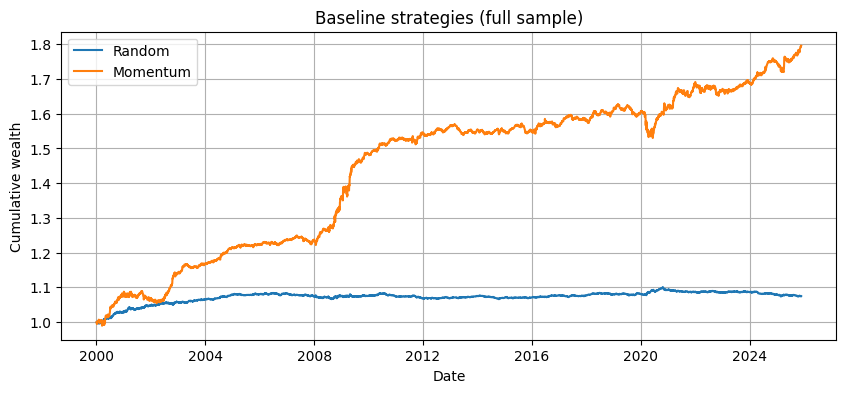

In [22]:
# -------------------------
# 3) Baseline signals + backtests
# -------------------------
bt = Backtester(ret_col="close_1d_ret")

# Random long/short baseline
panel["random_signal"] = SignalFactory.random_long_short(panel, seed=SEED)
daily_rand = bt.daily_returns(panel, panel["random_signal"])

# Momentum deciles on hedged return
panel["mom_signal"] = SignalFactory.cross_sectional_signal(panel, score_col="close_1d_ret_hedged", lag=1)
daily_mom = bt.daily_returns(panel, panel["mom_signal"])

print("Sharpe Random:", bt.sharpe(daily_rand))
print("Sharpe Momentum:", bt.sharpe(daily_mom))

# Plots (baseline)
Plotter.plot_cum_returns_compare(
    {"Random": daily_rand, "Momentum": daily_mom},
    title="Baseline strategies (full sample)"
)


=== Feature diagnostics ===
Feature: close_1d_ret_hedged
beta_global: 0.9657994927564061
bias: 0.013500342058109625
stability (%): 76.73252669099442
sharpe_ts: 33.25858183535433


/tmp/ipykernel_30061/3977881301.py:121: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return dff.groupby("Date").apply(_one_day)


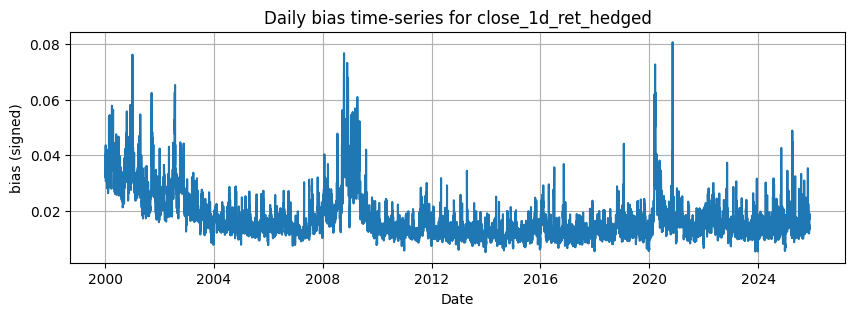

In [23]:
# -------------------------
# 4) Feature diagnostics (single-feature report)
# -------------------------
rep = FeatureReport(fit_intercept=False)

diag_feature = "close_1d_ret_hedged"
metrics = rep.single_feature(
    panel,
    feature=diag_feature,
    target="close_1d_ret",
    drop_extreme_perc=True,
    ts_bool=True
)

print("\n=== Feature diagnostics ===")
print("Feature:", diag_feature)
print("beta_global:", metrics["beta_global"])
print("bias:", metrics["bias"])
print("stability (%):", metrics["stability"])
print("sharpe_ts:", metrics["sharpe_ts"])

# Optional: plot bias_ts if you want (simple)
bias_ts = metrics["bias_ts"].dropna()
plt.figure(figsize=(10,3))
plt.plot(bias_ts)
plt.title(f"Daily bias time-series for {diag_feature}")
plt.xlabel("Date")
plt.ylabel("bias (signed)")
plt.grid(True)
plt.show()

In [24]:
# -------------------------
# 5) Train/Test split (time split by Date)
# -------------------------
dates = np.array(sorted(panel["Date"].unique()))
cut = int(0.8 * len(dates))
train_dates = set(dates[:cut])
test_dates = set(dates[cut:])

panel_train = panel[panel["Date"].isin(train_dates)].copy()
panel_test  = panel[panel["Date"].isin(test_dates)].copy()

print("[OK] Train/Test dates:", len(train_dates), len(test_dates))
print("[OK] Train/Test rows:", len(panel_train), len(panel_test))

[OK] Train/Test dates: 5211 1303
[OK] Train/Test rows: 1925954 483412


In [25]:
# -------------------------
# 6) Choose ML features (Regress-then-rank)
# -------------------------
# Start with BASE_FEATURES then optionally add a few MACD transformed features
BASE_FEATURES = [
    "close_1d_ret",
    "open_close_ret",
    "high_low_ret",
    "body_ratio",
    "dollar_volume",
    "turnover_proxy",
    "close_1d_ret_hedged",
    "mom_signal"
]
extra_macd = [c for c in panel.columns if c.startswith("macd_adj_first_") and c.endswith("_baz")]
feature_cols = BASE_FEATURES + extra_macd[:5]   # keep small to avoid overfitting / NaNs

print("\n[OK] ML feature columns:", feature_cols)


[OK] ML feature columns: ['close_1d_ret', 'open_close_ret', 'high_low_ret', 'body_ratio', 'dollar_volume', 'turnover_proxy', 'close_1d_ret_hedged', 'mom_signal', 'macd_adj_first_21_1_baz', 'macd_adj_first_21_2_baz', 'macd_adj_first_21_3_baz', 'macd_adj_first_63_1_baz', 'macd_adj_first_63_2_baz']


/opt/python/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.99022e-26): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/python/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.61322e-26): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/python/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.26772e-26): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/python/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.53576e-27): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/python/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.99018e-25): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/python/lib


=== Ridge alpha selection (train) ===
Best alpha: 1


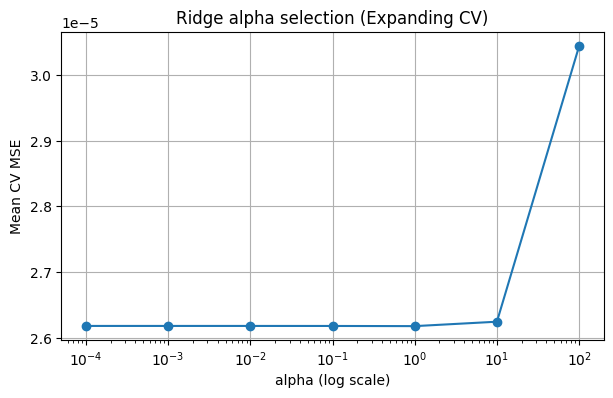

In [26]:
# -------------------------
# 7) Ridge alpha selection with Expanding CV (on TRAIN only)
# -------------------------
cv = ExpandingCV(ExpandingCVConfig(n_splits=5, lower=0.01, upper=0.01))
selector = RidgeAlphaSelector(cv)

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
best_alpha, cv_scores = selector.select_alpha(
    panel_train,
    feature_cols=feature_cols,
    target_col="close_1d_ret",
    alphas=alphas,
    winsor_lower=0.01,
    winsor_upper=0.01,
    fit_intercept=False
)

print("\n=== Ridge alpha selection (train) ===")
print("Best alpha:", best_alpha)
Plotter.plot_cv_curve(cv_scores, title="Ridge alpha selection (Expanding CV)")

In [27]:
# -------------------------
# 8) Regress-then-rank (fit on TRAIN, trade on TEST)
# -------------------------
cfg_rtr = RegressThenRankConfig(
    feature_cols=feature_cols,
    target_col="close_1d_ret",
    alpha=best_alpha,
    fit_intercept=False,
    winsor_lower=0.01,
    winsor_upper=0.01,
    lag_signal=1
)

rtr = RegressThenRank(cfg_rtr)
scores_test, signal_test = rtr.fit_predict_signal(panel_train, panel_test)

daily_rtr = bt.daily_returns(panel_test, signal_test)

print("\n=== Regress-then-rank (TEST) ===")
print("RTR Sharpe:", bt.sharpe(daily_rtr))
print("RTR Test MSE:", rtr.mse(panel_test))

/opt/python/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.57455e-22): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/tmp/ipykernel_30061/2530721322.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return tmp.groupby("Date").apply(lambda g: (g["_signal"] * g[self.ret_col]).mean())



=== Regress-then-rank (TEST) ===
RTR Sharpe: 1.1250952239202605
RTR Test MSE: 1.8341526494265997e-05



=== Test Sharpe Comparison ===
Momentum (test) Sharpe: 1.1207718120821966
Random   (test) Sharpe: -0.6420173583697654
RTR      (test) Sharpe: 1.1250952239202605


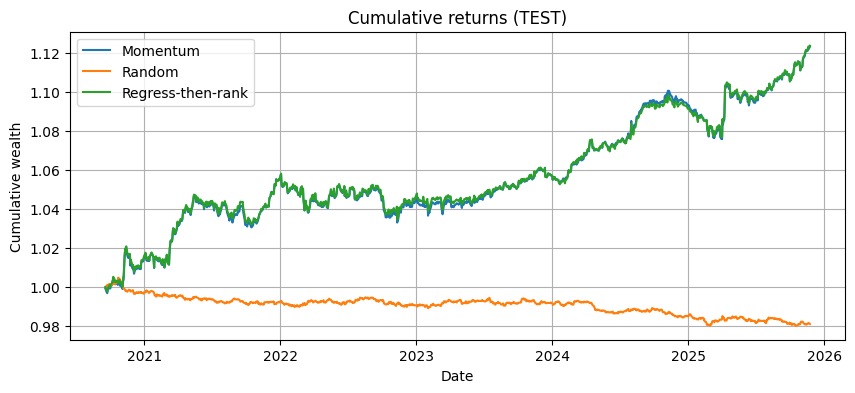

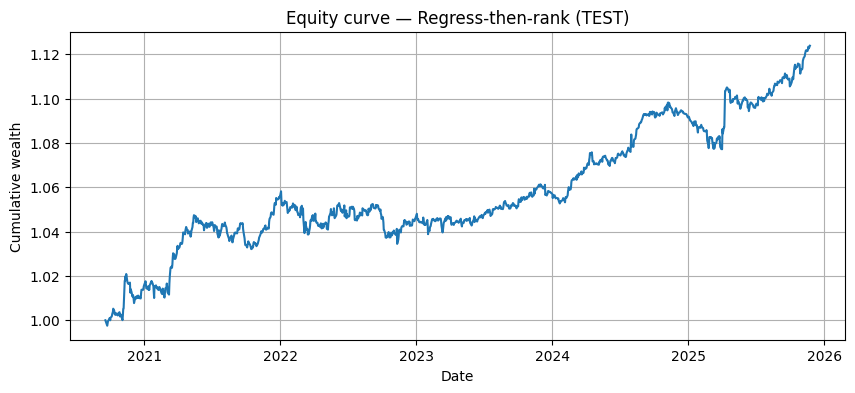

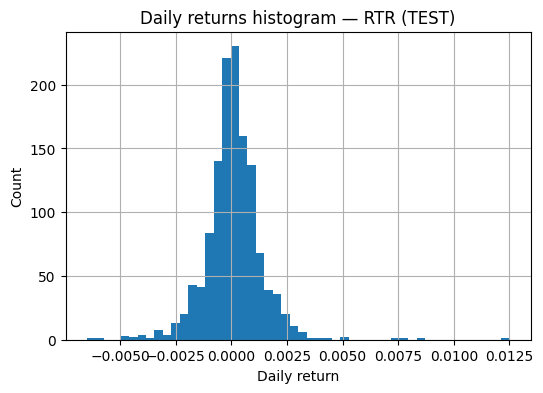

In [28]:
# -------------------------
# 9) Compare strategies on TEST only + plots
# -------------------------
# To compare fairly, restrict to common date range
common_idx = daily_rtr.index.intersection(daily_mom.index)

daily_mom_test = daily_mom.loc[common_idx]
daily_rand_test = daily_rand.loc[common_idx]
daily_rtr_test = daily_rtr.loc[common_idx]

print("\n=== Test Sharpe Comparison ===")
print("Momentum (test) Sharpe:", bt.sharpe(daily_mom_test))
print("Random   (test) Sharpe:", bt.sharpe(daily_rand_test))
print("RTR      (test) Sharpe:", bt.sharpe(daily_rtr_test))

Plotter.plot_cum_returns_compare(
    {"Momentum": daily_mom_test, "Random": daily_rand_test, "Regress-then-rank": daily_rtr_test},
    title="Cumulative returns (TEST)"
)

Plotter.plot_equity_curve(daily_rtr_test, title="Equity curve — Regress-then-rank (TEST)")
Plotter.plot_daily_return_hist(daily_rtr_test, title="Daily returns histogram — RTR (TEST)")

In [29]:
# ============================
# EXPERIMENTS (FINAL COMPARISON)
# ============================

# ---- 1) Evaluate helpers (keep in experiments section) ----
import matplotlib.pyplot as plt

class Performance:
    @staticmethod
    def equity_curve(daily_ret: pd.Series):
        return (1.0 + daily_ret.fillna(0.0)).cumprod()

    @staticmethod
    def sharpe(daily_ret: pd.Series, ann=252):
        r = daily_ret.dropna()
        return np.sqrt(ann) * r.mean() / (r.std(ddof=1) + 1e-12)

    @staticmethod
    def max_drawdown(daily_ret: pd.Series):
        eq = Performance.equity_curve(daily_ret)
        peak = eq.cummax()
        dd = eq / peak - 1.0
        return float(dd.min())

class ExperimentPlotter:
    @staticmethod
    def plot_equity(results: Dict[str, pd.Series], title="Equity curves (TEST)"):
        plt.figure(figsize=(12, 5))
        for name, r in results.items():
            eq = Performance.equity_curve(r)
            plt.plot(eq.index, eq.values, label=name)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def summary_table(results: Dict[str, pd.Series]) -> pd.DataFrame:
        rows = []
        for name, r in results.items():
            rows.append({
                "name": name,
                "sharpe": Performance.sharpe(r),
                "max_dd": Performance.max_drawdown(r),
            })
        return pd.DataFrame(rows).set_index("name").sort_values("sharpe", ascending=False)

In [30]:
# ---- 2) Build LTR datasets (train/test) ----
ltr_builder = LTRDatasetBuilder(feature_cols=feature_cols, target_col="close_1d_ret", n_quantiles=5, min_group_size=5)

X_train_ltr, y_train_ltr, group_train = ltr_builder.build(panel_train)
X_test_ltr,  y_test_ltr,  group_test  = ltr_builder.build(panel_test)

# We need scores indexed like panel_test rows.
# We'll align by building a "mask panel" that matches the dataset builder output ordering.
panel_test_clean = panel_test.dropna(subset=feature_cols + ["close_1d_ret"]).sort_values(["Date", "Ticker"]).copy()
panel_test_clean_idx = panel_test_clean.index  # indices correspond to X_test_ltr rows

In [31]:
# ---- 3) Fit two LTR models ----
ranker_pairwise = LightGBMRanker(objective="lambdarank", n_estimators=400, learning_rate=0.05)
ranker_listwise = LightGBMRanker(objective="rank_xendcg", n_estimators=400, learning_rate=0.05)

ranker_pairwise.fit(X_train_ltr, y_train_ltr, group_train)
ranker_listwise.fit(X_train_ltr, y_train_ltr, group_train)

scores_pairwise = pd.Series(ranker_pairwise.predict_scores(X_test_ltr), index=panel_test_clean_idx)
scores_listwise = pd.Series(ranker_listwise.predict_scores(X_test_ltr), index=panel_test_clean_idx)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 1879579, number of used features: 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [32]:
# ---- 4) Scores -> signals -> backtest ----
sts = ScoreToSignal(top_q=0.2, bottom_q=0.2, lag=1, min_group_size=5)

sig_pairwise = sts.make_signal(panel_test, scores_pairwise)
sig_listwise = sts.make_signal(panel_test, scores_listwise)

daily_pairwise = bt.daily_returns(panel_test, sig_pairwise)
daily_listwise = bt.daily_returns(panel_test, sig_listwise)

/tmp/ipykernel_30061/2530721322.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return tmp.groupby("Date").apply(lambda g: (g["_signal"] * g[self.ret_col]).mean())
/tmp/ipykernel_30061/2530721322.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return tmp.groupby("Date").apply(lambda g: (g["_signal"] * g[self.ret_col]).mean())


In [33]:
# ---- 5) Collect + align all results ----
results = {
    "Random": daily_rand_test,
    "Momentum": daily_mom_test,
    "Ridge RTR": daily_rtr_test,
    "LTR lambdarank (pairwise grads)": daily_pairwise,
    "LTR rank_xendcg (listwise-ish)": daily_listwise,
}

,sharpe,max_dd
name,,
Ridge RTR,1.125095,-0.022399
Momentum,1.120772,-0.023627
Random,-0.642017,-0.024519
LTR rank_xendcg (listwise-ish),-0.997018,-0.002256
LTR lambdarank (pairwise grads),-1.040309,-0.002244


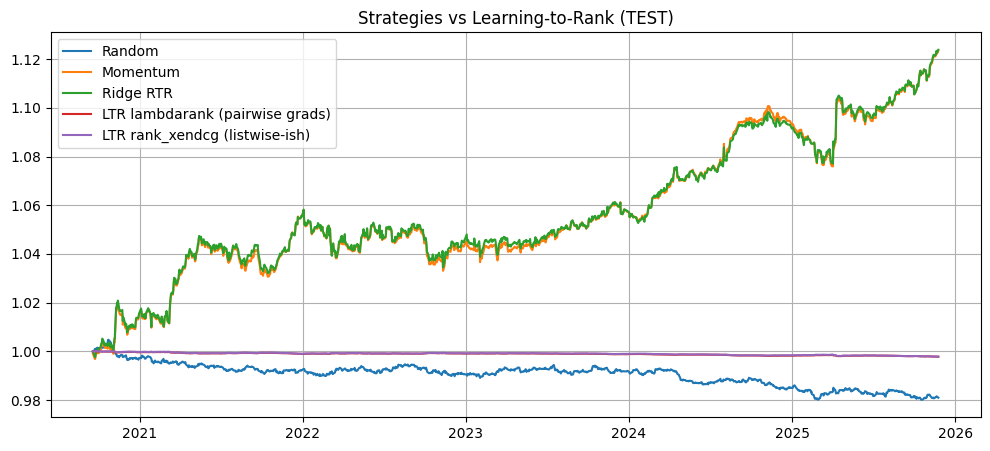

In [34]:
# Align dates
common_idx = None
for r in results.values():
    common_idx = r.index if common_idx is None else common_idx.intersection(r.index)
results = {k: v.loc[common_idx] for k, v in results.items()}

# ---- 6) Summary + plots ----
display(ExperimentPlotter.summary_table(results))
ExperimentPlotter.plot_equity(results, title="Strategies vs Learning-to-Rank (TEST)")

#### Conclusion
Learning-to-Rank, when naively applied to financial returns, can underperform even random strategies due to noise, lack of temporal regularization, and misalignment between ranking loss and portfolio objectives.